In [137]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
%matplotlib inline
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
import seaborn as sns

# Definition for swap calculation

In [64]:
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
        end = ql.TARGET().advance(start, maturity)
        fixedLegTenor = ql.Period("1y")
        fixedLegBDC = ql.ModifiedFollowing
        fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
        spread = 0.0
        fixedSchedule = ql.Schedule(start, end,  fixedLegTenor,   index.fixingCalendar(),   fixedLegBDC,  fixedLegBDC,   ql.DateGeneration.Backward,   False)
        floatSchedule = ql.Schedule(start, end,  index.tenor(),  index.fixingCalendar(),   index.businessDayConvention(),  index.businessDayConvention(),   ql.DateGeneration.Backward,  False)
        swap = ql.VanillaSwap(typ,  nominal,  fixedSchedule,  fixedRate,  fixedLegDC,  floatSchedule,  index,  spread,  index.dayCounter())
        return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

def makeSwaption(swap, callDates, settlement):
    if len(callDates) == 1:
        exercise = ql.EuropeanExercise(callDates[0])
    else:
        exercise = ql.BermudanExercise(callDates)
    return ql.Swaption(swap, exercise, settlement)

def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def getFixedLeg(swap, t):
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    npv = 0
    for i in range(n):
        cf = fixed_leg[i]
        t_i = timeFromReference(cf.date())
        if t_i > t:
            fixed_times.append(t_i)
            fixed_amounts.append(cf.amount())
    return np.array(fixed_times), np.array(fixed_amounts)

def getFloatingLeg(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        # convert base classiborstart_idx Cashflow to
        # FloatingRateCoupon
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf.append(cf.accrualPeriod())
            # calculate the start and end time
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            # payment time
            float_times.append(t_i)
            # nominals 
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)
    
def getFixedFloatingPeriod(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i < t and t < t_i:
            iborIndex = cf.index()         
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf = cf.accrualPeriod()
            # calculate the start and end time
            accrual_start_time = t_fix_i
            accrual_end_time = timeFromReference(index_mat)
            # payment time
            float_times = t_i
            # nominals 
            nominals = cf.nominal()
            return (float(float_times), float(float_dcf), float(accrual_start_time), float(accrual_end_time), float(nominals))
    return (float(t), 1., float(t), float(t), 0.)

def swapPathNPV(swap, t, timegrid):
    fixed_times, fixed_amounts = getFixedLeg(swap, t)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
    df_times = np.concatenate([fixed_times,  accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in 
    # the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times 
    # in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time
    # in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    paytime_ffp, float_dcf_ffp, accrual_start_time_ffp, accrual_end_time_ffp, nominals_ffp = getFixedFloatingPeriod(swap, t)
    # Calculate NPV
    def calc(path):
        if len(df_times)==0:
            return 0
        i = np.where(timegrid == t)[0][0]
        x_t = path[i]
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        # Calculate the already fixed accrual period of the floating leg
        t_f = accrual_start_time_ffp
        i = np.where(timegrid == t_f)[0][0]
        x_f = path[i]
        df_e = model.zerobond(accrual_end_time_ffp, t_f, x_f)
        npv_accrualperiod = (1. / df_e - 1) * nominals_ffp * model.zerobond(paytime_ffp, t, x_t)
        # Calculate swap npv
        npv = float_leg_npv + npv_accrualperiod - fix_leg_npv
        return npv
    return calc
    
def fixingdates(swap):
    leg = swap.leg(1)
    n = len(leg)
    fixing_dates = []
    for i in range(0, n):
        cf = ql.as_floating_rate_coupon(leg[i])
        value_date = cf.referencePeriodStart()
        fixing_dates.append(value_date)
    return fixing_dates 

today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)
settlementDate = today + ql.Period("2D") 

# Calculation of CVA VaR

the swap has maturity of 5 yrs, fixed leg = 1 yr, float leg = 6m. 

In [150]:
df = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/Libor.csv', header=None) 
Libor = np.array(df.iloc[:,1])
test = np.array([ 0.014,  0.035,  0.056])

In [151]:
dist_CVA_1 = []
CVA_VaR = []

In [152]:
for itr in test:
    fixedRate = itr + 0.002      # fixed rate must be larger than float so value of swap is 0 at inception.
    rate = ql.SimpleQuote(itr)   # Libor + 1% floating rate
    rate_handle = ql.QuoteHandle(rate)
    dc = ql.Actual365Fixed()
    yts = ql.FlatForward(today, rate_handle, dc)
    yts.enableExtrapolation()
    hyts = ql.RelinkableYieldTermStructureHandle(yts)
    t0_curve = ql.YieldTermStructureHandle(yts)
    libor1yr = ql.USDLibor(ql.Period(6, ql.Months), hyts)  
    cal = ql.TARGET()
    
    swaps = [makeSwap(settlementDate,  ql.Period("5Y"), 1e6,  fixedRate,  libor1yr) ]
    calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
    calldates = [libor1yr.valueDate(d) for d in calldates]

    engine = ql.DiscountingSwapEngine(hyts)
    for swap, fixingDates in swaps:
        swap.setPricingEngine(engine)
    
    # Assume the model is already calibrated either historical or market implied
    volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)), ql.QuoteHandle(ql.SimpleQuote(0.0075))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
    model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
    process = model.stateProcess()
    
    mcDC = yts.dayCounter()
    timeFromReference = timeFromReferenceFactory(mcDC, today)
    
    callTimes = timeFromReference(calldates)
    swap = swaps[0][0]
    npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))
    
    fixing_dates = fixingdates(swap)
    fixing_times = timeFromReference(fixing_dates )

    date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    time_grid = np.unique(time_grid)
    dt = time_grid[1:] - time_grid[:-1]
    
    seed = 1
    urng = ql.MersenneTwisterUniformRng(seed)
    usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

    M = 10000
    m = len(time_grid)
    x = np.zeros((M, m))
    y = np.zeros((M, m))
    numeraires = np.zeros((M, m))
                      
    for n in range(0, M):
        numeraires[n, 0] = model.numeraire(0, 0)
    
    for n in range(0,M):
        dWs = generator.nextSequence().value()
        j = 1
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            e = process.expectation(t0, x[n,i-1],   dt[i-1])
            std = process.stdDeviation(t0,   x[n,i-1],  dt[i-1])
            x[n,i] = e + dWs[i-1] * std 
            e_0_0 = process.expectation(0,0,t1)
            std_0_0 = process.stdDeviation(0,0,t1)
            y[n,i] = (x[n,i] - e_0_0) / std_0_0
            numeraires[n, i] = model.numeraire(t1, y[n,i])
        
    swap_npvs = np.zeros((M, m))
    cont_value = np.zeros(numeraires[:,i].shape)
    for i in range(m-1, 0, -1):
        t = time_grid[i]
        pricer = swapPathNPV(swap, t, time_grid)
        swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]
        exercise_values = np.zeros(numeraires[:,i].shape)
        if t in callTimes:
            exercise_values = swap_npvs[:, i].copy()
            exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(cont_value, Y)
        ols_result = ols.fit()
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        if t in callTimes:
            cont_value = np.maximum(cont_value_hat, exercise_values)
    swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]
    swap_npvs *= numeraires[0,0]
    swap_npvs[swap_npvs<0] = 0
    EE_swap = np.mean(swap_npvs, axis=0)
    
    # calculation of current CVA
    pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
    hzrates = np.repeat(0.4, 11)
    pd_curve = ql.HazardRateCurve(pd_dates, hzrates, ql.Actual365Fixed())
    pd_curve.enableExtrapolation()
    
    defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
    dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])
    recovery = 0.4
    CVA_0 = (1-recovery) * np.sum(EE_swap[1:] * dPD)
    
    # calculation of 1 yr CVA
    noise_number = 1000
    CVA_1 = np.zeros(noise_number)
    pd_dates_1 = [today + ql.Period(1, ql.Years) + ql.Period(i, ql.Years) for i in range(9)]
    hzrates_1 = np.random.normal(0.4, 0.1, noise_number)
    hzrates_1[hzrates_1 < 0] = 0
    
    for i in range(1000):
        pd_curve_1 = ql.HazardRateCurve(pd_dates_1, np.repeat(hzrates_1[i], len(pd_dates_1)) , ql.Actual365Fixed())
        pd_curve_1.enableExtrapolation()
        defaultProb_vec_1 = np.vectorize(pd_curve_1.defaultProbability)
        dPD_1 = defaultProb_vec_1(time_grid[:-3], time_grid[3:])   # from the 4th time grid, which is the first cash flow after yr 1
        CVA_1[i] = (1-recovery) * np.sum(EE_swap[3:] * dPD_1)
    
    dist_CVA_1.append(CVA_1)
    
    # calculation of CVA VaR 
    VaR = np.percentile(np.array(CVA_1 - CVA_0), 90) # 90% quantile as VaR 
    CVA_VaR.append(VaR)   
    
    print VaR

6241.08174536
5515.65010437
5711.51979572


/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


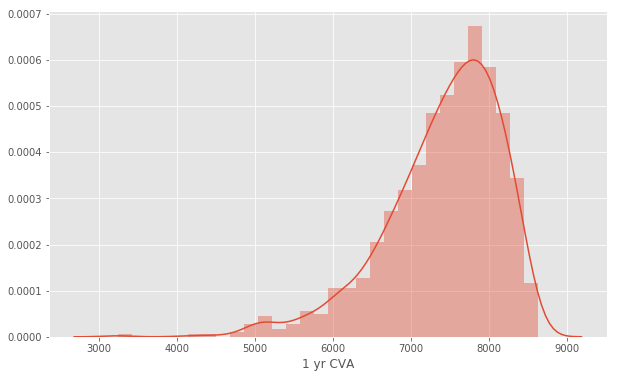

In [153]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.xlabel('1 yr CVA')
sns.distplot(dist_CVA_1[2], hist=True, bins = 30)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


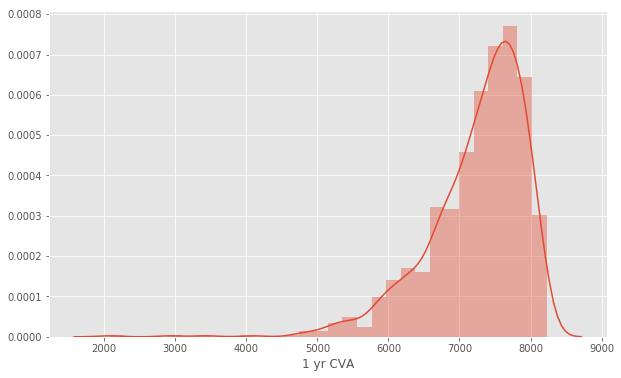

In [154]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.xlabel('1 yr CVA')
sns.distplot(dist_CVA_1[1], hist=True, bins = 30)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


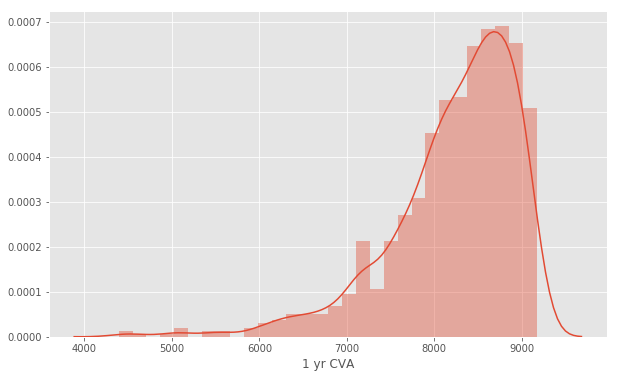

In [155]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.xlabel('1 yr CVA')
sns.distplot(dist_CVA_1[0], hist=True, bins = 30)